In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/corona-virus-report/covid_19_clean_complete.csv
/kaggle/input/corona-virus-report/complete_data_new_format.csv


# New cases of Covid-19 forecasting with SES and Holt's models

> This notebook follows the spread of COVID-19, which is the disease caused by the new coronavirus that emerged in China in December 2019.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, breathing difficulties. 

# Data preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from math import exp

data = pd.read_csv("/kaggle/input/corona-virus-report/complete_data_new_format.csv")
data.head()
data['Date'] =pd.to_datetime(data.Date)
country = data.iloc[:,1]
date = data.iloc[:,4]
confirmed = data.iloc[:,5]
deaths = data.iloc[:,6]
country_unique = set(country)
latest_country_cases =data[data['Date'] == max(data['Date'])].reset_index()
latest_country_cases=latest_country_cases.groupby(["Country/Region"])['Confirmed', 'Deaths'].sum().reset_index()



# Latest data overview 

In [3]:
pd.set_option('display.max_columns', None)
latest_country_cases.style.background_gradient(cmap='Purples')
latest_country_cases.sort_values(by = ['Confirmed'], ascending=False).reset_index()

,index,Country/Region,Confirmed,Deaths
0,33,China,81661,3285
1,81,Italy,74386,7503
2,162,US,65778,942
3,147,Spain,49515,3647
4,62,Germany,37323,206
...,...,...,...,...
169,157,Timor-Leste,1,0
170,144,Somalia,1,0
171,93,Libya,1,0
172,135,Saint Vincent and the Grenadines,1,0


# Confirmed cases over time for top 10 countries

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


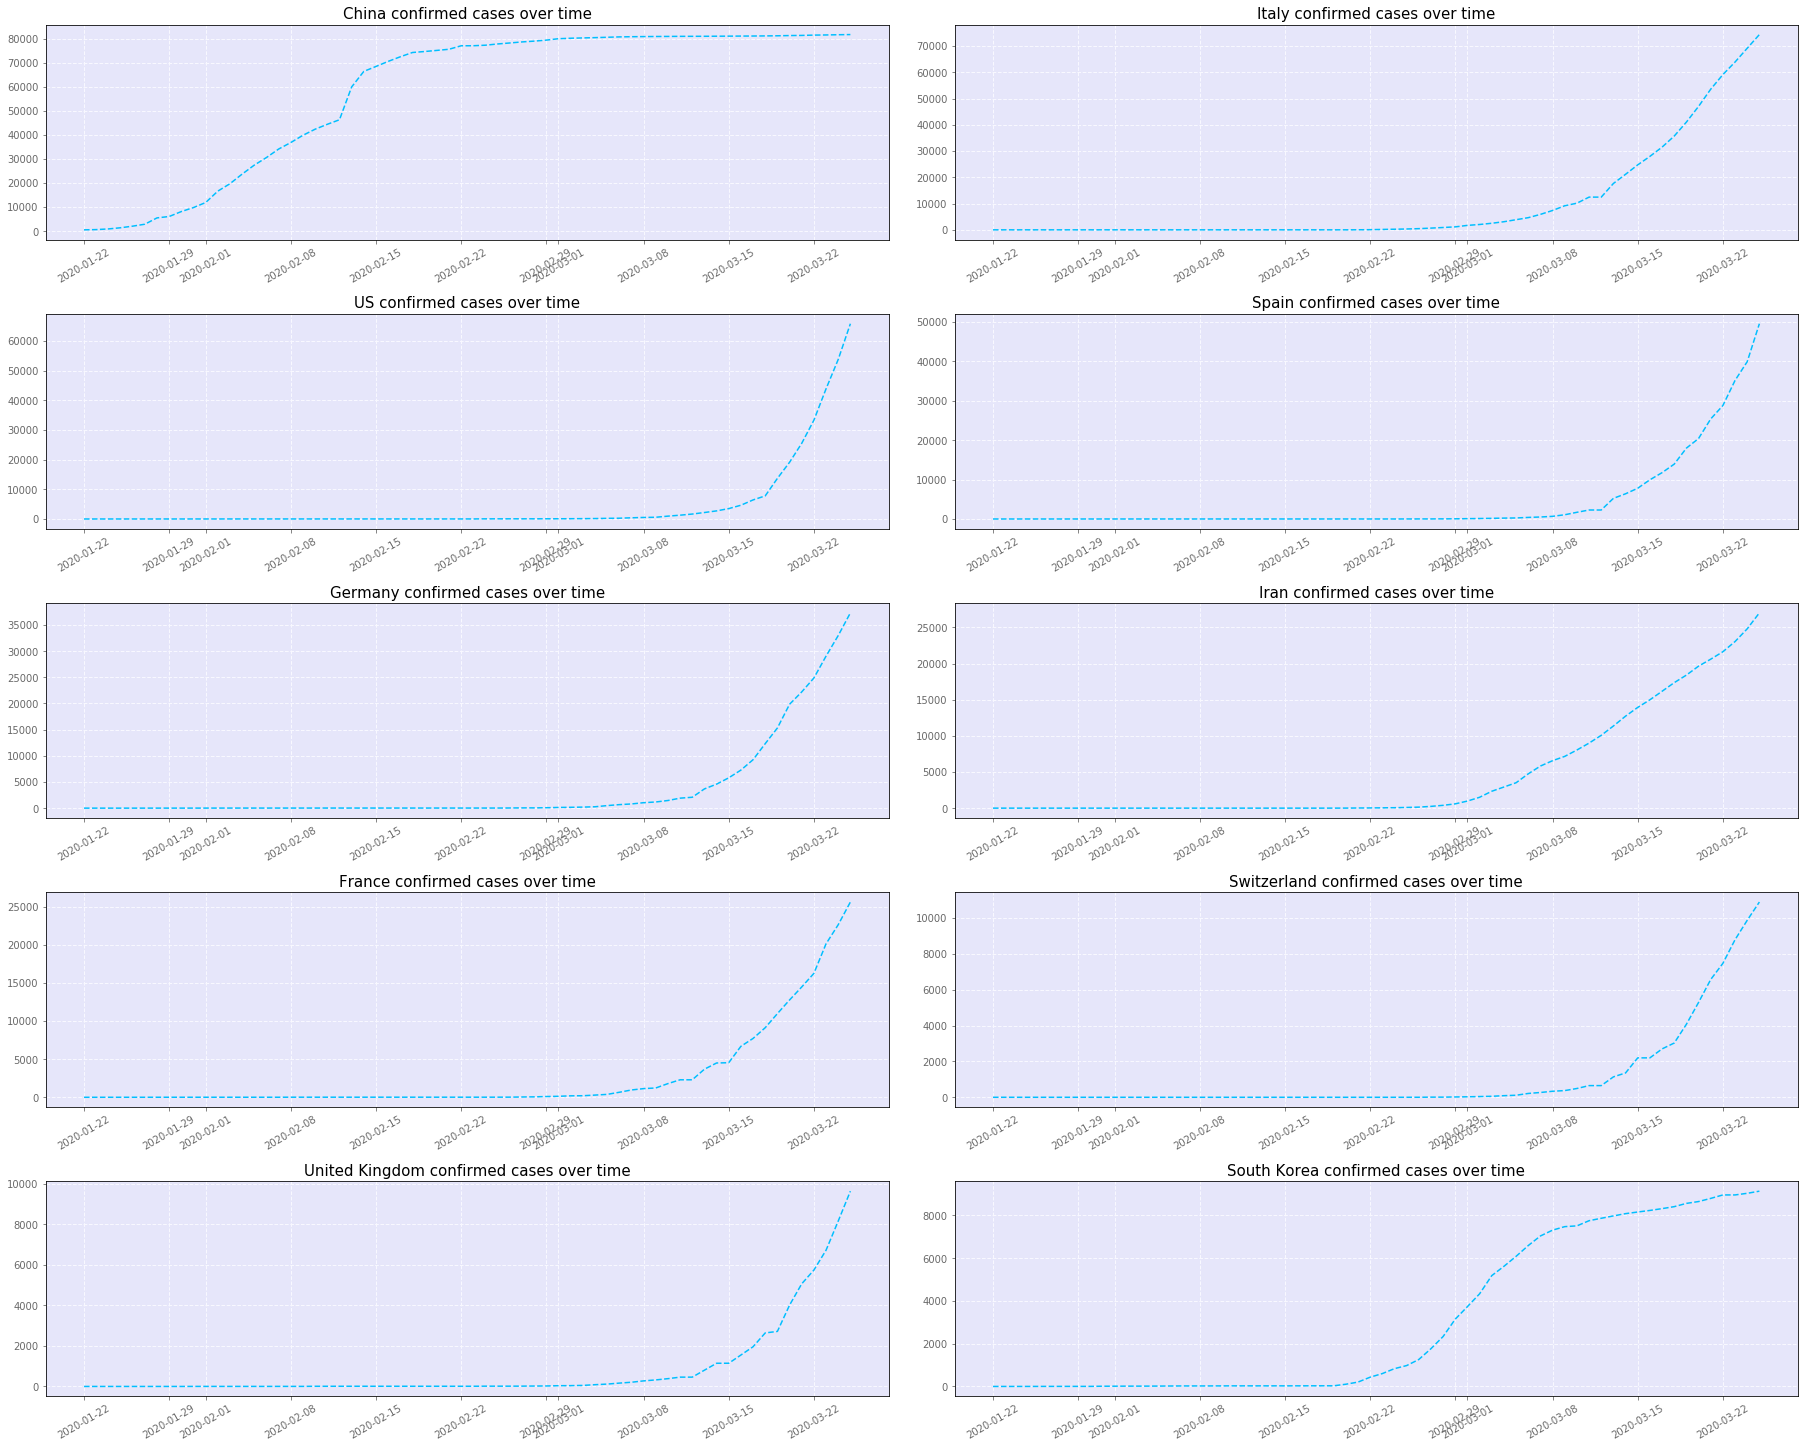

In [4]:
%matplotlib inline

top_10_countries = latest_country_cases.nlargest(10,['Confirmed']).reset_index(drop=True)
top_10_countries.style.background_gradient(cmap='Reds')
top_10_names = list(top_10_countries['Country/Region'])



plot_data = {}
fig, ax = plt.subplots(5,2, figsize=(25,20), constrained_layout=True)
ax = ax.flatten()

for  i, country in enumerate(top_10_names):
    plot_data[country] = data.loc[data['Country/Region'] == country]
    plot_data[country]=plot_data[country].groupby(["Date"]).sum().sort_values(by = ['Date']).reset_index()
    ax[i].plot(plot_data[country]['Date'], plot_data[country]['Confirmed'], linestyle = "--", color = 'deepskyblue')
    ax[i].set_title(country + ' confirmed cases over time', fontsize = 15)
    ax[i].set_facecolor('lavender')
    ax[i].grid(color='ghostwhite', linestyle='--', linewidth=1)
    ax[i].xaxis.set_tick_params(labelsize=10, rotation = 30)
    ax[i].yaxis.set_tick_params(labelsize=10)
    ax[i].xaxis.set_tick_params(color = 'dimgray', labelsize=10, rotation = 30)
    ax[i].yaxis.set_tick_params(color = 'dimgray', labelsize=10)
    ax[i].tick_params(axis='x', colors='dimgray')
    ax[i].tick_params(axis='y', colors='dimgray')
    

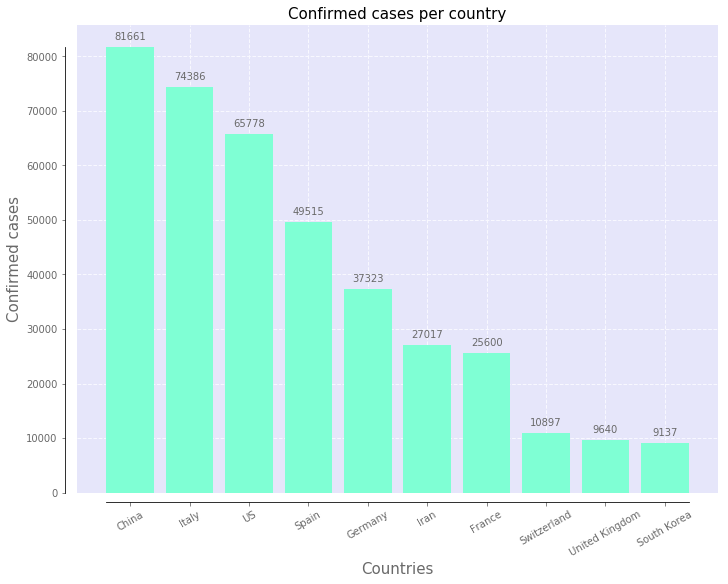

In [5]:
fig = plt.figure(figsize= [10,8],constrained_layout=True)
bar = plt.gca()
plt.bar(top_10_countries['Country/Region'], top_10_countries['Confirmed'], color = 'aquamarine')
bar.set_title('Confirmed cases per country', fontsize = 15)
bar.set_facecolor('lavender')
bar.set_axisbelow(True)
bar.set_xlabel('Countries', fontsize=15, color = 'dimgray')
bar.set_ylabel('Confirmed cases', fontsize=15, color = 'dimgray')


bar.grid(color='ghostwhite', linestyle='--', linewidth=1)
bar.spines['bottom'].set_position(('axes', -0.02))
bar.spines['left'].set_position(('axes', -0.02))
plt.rcParams['axes.edgecolor']='dimgrey'
bar.spines['top'].set_color('none')
bar.spines['right'].set_color('none')
bar.spines['left'].set_smart_bounds(True)
bar.spines['bottom'].set_smart_bounds(True)
bar.xaxis.set_tick_params(color = 'dimgray', labelsize=10, rotation = 30)
bar.yaxis.set_tick_params(color = 'dimgray', labelsize=10)
bar.tick_params(axis='x', colors='dimgray')
bar.tick_params(axis='y', colors='dimgray')

for column in bar.patches:
    height = column.get_height()
    bar.text(column.get_x() + column.get_width()/2., height + 1000,
        int(height),
        ha='center', va='bottom', fontsize = 10, color = 'dimgray')


# Forecasting models for China cases using Simple Exponential Smoothing models and Holt's models

Stationarity check using Augmented Dickey–Fuller test.


The null hypothesis for this test is that there is a unit root. Alternate hypothesis is that the time series is stationary.

In [6]:
data_china = data.loc[data['Country/Region'] == 'China']
data_china= data_china.groupby(["Date"]).sum().sort_values(by = ['Date']).reset_index()

df_test = adfuller(data_china['Confirmed'], autolag='AIC')

p_value = df_test[1]
confidence_levels = [0.01,0.05,0.1]


for i in confidence_levels:
    if p_value > i:
        print('The data is not stationary with '+ str(int(round(i*100,0))) + '% confidence') 
    else:
        print('The data is stationary with '+ str(i) + '% confidence') 
    

The data is not stationary with 1% confidence
The data is not stationary with 5% confidence
The data is not stationary with 10% confidence


Autocorrelation function and the partial autocorrelation function

* An autocorrelation (ACF) plot shows the autocorrelation of the series with lags of itself.
* A partial autocorrelation (PACF) plot shows the amount of correlation between a data(series) and its lag.

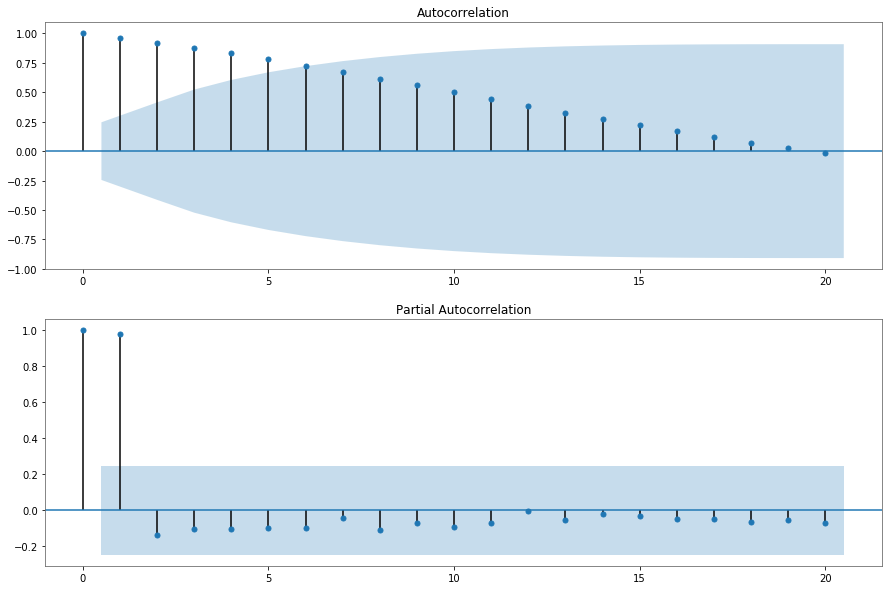

In [7]:
fig, ax = plt.subplots(2, figsize=(15,10))

ax[0] = plot_acf(data_china['Confirmed'], ax=ax[0], lags=20)
ax[1] = plot_pacf(data_china['Confirmed'], ax=ax[1], lags=20)




Density plot

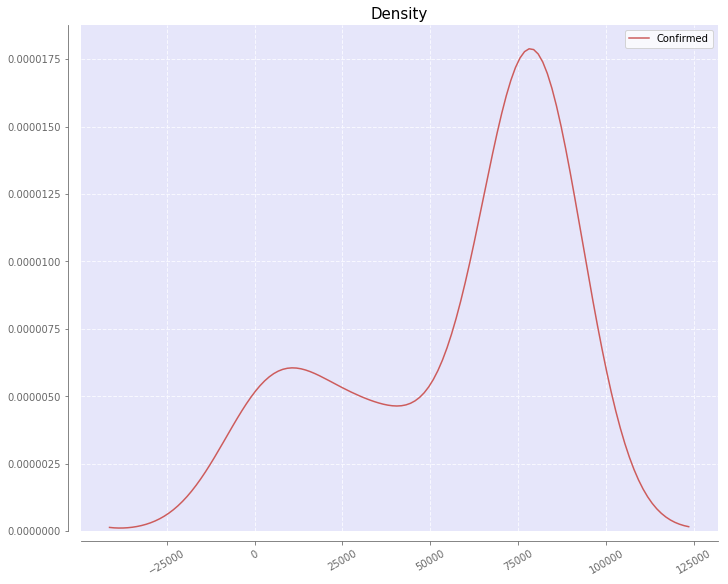

In [8]:
fig = plt.figure(figsize= [10,8],constrained_layout=True)

densityplot = sns.kdeplot(data_china['Confirmed'], color = 'indianred')
densityplot = plt.gca()
densityplot.set_title('Density', fontsize = 15)
densityplot.set_facecolor('lavender')
densityplot.grid(color='ghostwhite', linestyle='--', linewidth=1)
densityplot.spines['bottom'].set_position(('axes', -0.02))
densityplot.spines['left'].set_position(('axes', -0.02))
densityplot.spines['top'].set_color('none')
densityplot.spines['right'].set_color('none')
densityplot.tick_params(axis='x', colors='dimgray')
densityplot.tick_params(axis='y', colors='dimgray')
densityplot.xaxis.set_tick_params(color = 'dimgray', labelsize=10, rotation = 30)
densityplot.yaxis.set_tick_params(color = 'dimgray', labelsize=10)

Data Preparation for models creation

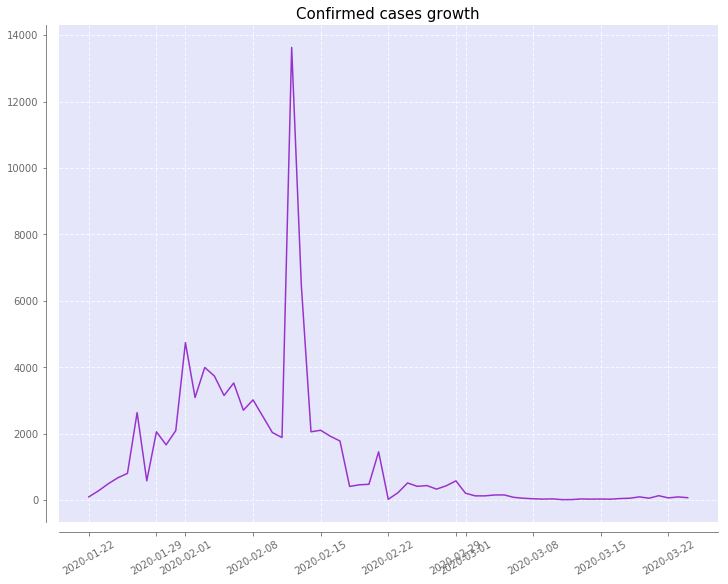

In [9]:
diff_china_confirmed = np.diff(data_china['Confirmed'])
date_china = data_china['Date'][:-1]

fig = plt.figure(figsize= [10,8],constrained_layout=True)
diff_plot = plt.gca()
plt.plot(date_china, diff_china_confirmed, color = 'darkorchid')
diff_plot.set_title('Confirmed cases growth', fontsize = 15)
diff_plot.set_facecolor('lavender')
diff_plot.grid(color='ghostwhite', linestyle='--', linewidth=1)
diff_plot.spines['bottom'].set_position(('axes', -0.02))
diff_plot.spines['left'].set_position(('axes', -0.02))
diff_plot.spines['top'].set_color('none')
diff_plot.spines['right'].set_color('none')
diff_plot.tick_params(axis='x', colors='dimgray')
diff_plot.tick_params(axis='y', colors='dimgray')
diff_plot.xaxis.set_tick_params(color = 'dimgray', labelsize=10, rotation = 30)
diff_plot.yaxis.set_tick_params(color = 'dimgray', labelsize=10)

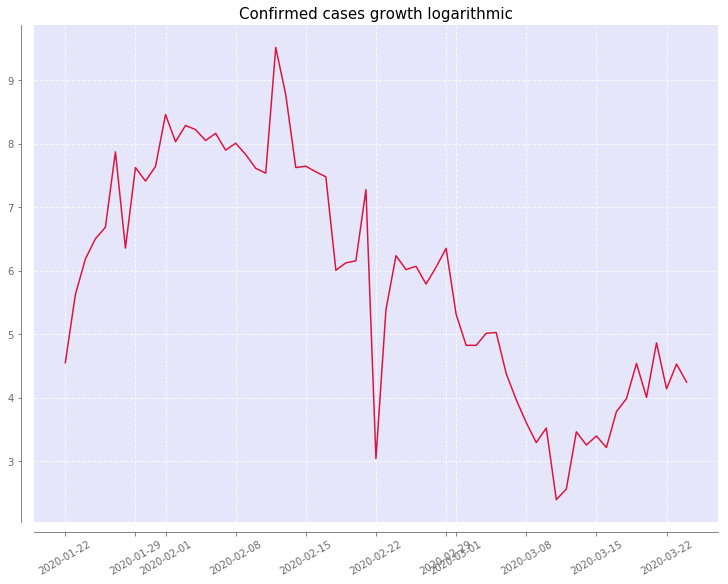

In [10]:
log_diff_china_confirmed = np.log(diff_china_confirmed)

fig = plt.figure(figsize= [10,8],constrained_layout=True)
log_plot = plt.gca()
plt.plot(date_china, log_diff_china_confirmed, color = 'crimson')
log_plot.set_title('Confirmed cases growth logarithmic', fontsize = 15)
log_plot.set_facecolor('lavender')
log_plot.grid(color='ghostwhite', linestyle='--', linewidth=1)
log_plot.spines['bottom'].set_position(('axes', -0.02))
log_plot.spines['left'].set_position(('axes', -0.02))
log_plot.spines['top'].set_color('none')
log_plot.spines['right'].set_color('none')
log_plot.tick_params(axis='x', colors='dimgray')
log_plot.tick_params(axis='y', colors='dimgray')
log_plot.xaxis.set_tick_params(color = 'dimgray', labelsize=10, rotation = 30)
log_plot.yaxis.set_tick_params(color = 'dimgray', labelsize=10)

Simple Exponential Smoothing model for:
* alpha = 0.2
* alpha = 0.6
* alpha = 0.57

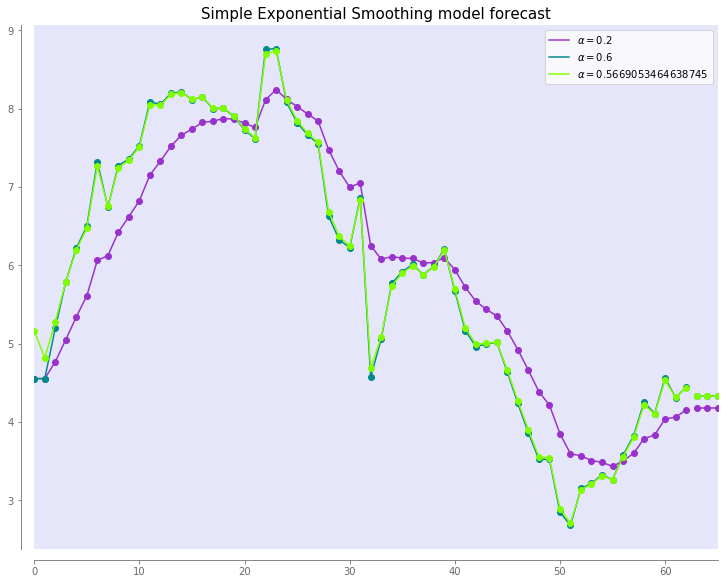

In [11]:
log_diff_china_confirmed_df = pd.DataFrame(log_diff_china_confirmed)

SES_02 = SimpleExpSmoothing(log_diff_china_confirmed_df).fit(smoothing_level=0.2,optimized=False)
forecast_02 = SES_02.forecast(3).rename(r'$\alpha=0.2$')

SES_06 = SimpleExpSmoothing(log_diff_china_confirmed_df).fit(smoothing_level=0.6,optimized=False)
forecast_06 = SES_06.forecast(3).rename(r'$\alpha=0.6$')

SES = SimpleExpSmoothing(log_diff_china_confirmed_df).fit()
forecast_SES = SES.forecast(3).rename(r'$\alpha=%s$'%SES.model.params['smoothing_level'])

fig = plt.figure(figsize= [10,8],constrained_layout=True)
SES_plot = fig.gca()
SES_plot.set_facecolor('lavender')
SES_plot.set_title('Simple Exponential Smoothing model forecast', fontsize = 15)
SES_plot.grid(color='ghostwhite', linestyle='--', linewidth=1)
SES_plot.spines['bottom'].set_position(('axes', -0.02))
SES_plot.spines['left'].set_position(('axes', -0.02))
SES_plot.spines['top'].set_color('none')
SES_plot.spines['right'].set_color('none')
SES_plot.tick_params(axis='x', colors='dimgray')
SES_plot.tick_params(axis='y', colors='dimgray')
SES_plot.xaxis.set_tick_params(color = 'dimgray', labelsize=10, rotation = 30)
SES_plot.yaxis.set_tick_params(color = 'dimgray', labelsize=10)


forecast_02.plot(marker='o', color='darkorchid', legend=True)
SES_02.fittedvalues.plot(marker='o',  color='darkorchid')

forecast_06.plot(marker='o', color='darkcyan', legend=True)
SES_06.fittedvalues.plot(marker='o',  color='darkcyan')

forecast_SES.plot(marker='o', color='chartreuse', legend=True)
SES.fittedvalues.plot(marker='o',  color='chartreuse')

plt.show()

In [12]:
forecast_02_real = []
for forecast in forecast_02:
    real_forecast = exp(forecast)
    forecast_02_real.append(real_forecast)
    
    
forecast_06_real = []
for forecast in forecast_06:
    real_forecast = exp(forecast)
    forecast_06_real.append(real_forecast)


forecast_real = []
for forecast in forecast_SES:
    real_forecast = exp(forecast)
    forecast_real.append(real_forecast)

real_forecasts_China = {'Simple exponential smoothing alpha = 02': [forecast_02_real[1]], 'Simple exponential smoothing alpha = 06': [forecast_06_real[1]], 'Simple exponential smoothing alpha = auto': [forecast_real[1]]}
index = ['Forecast']
real_forecasts_China = pd.DataFrame(real_forecasts_China, index=index)
real_forecasts_China = real_forecasts_China.transpose()
real_forecasts_China.style.background_gradient(cmap='Blues')
print(real_forecasts_China)

                                            Forecast
Simple exponential smoothing alpha = 02    64.934895
Simple exponential smoothing alpha = 06    75.694316
Simple exponential smoothing alpha = auto  75.970558


Holt's models:
* Holt's linear trend
* Exponential trend
* Additive damped trend

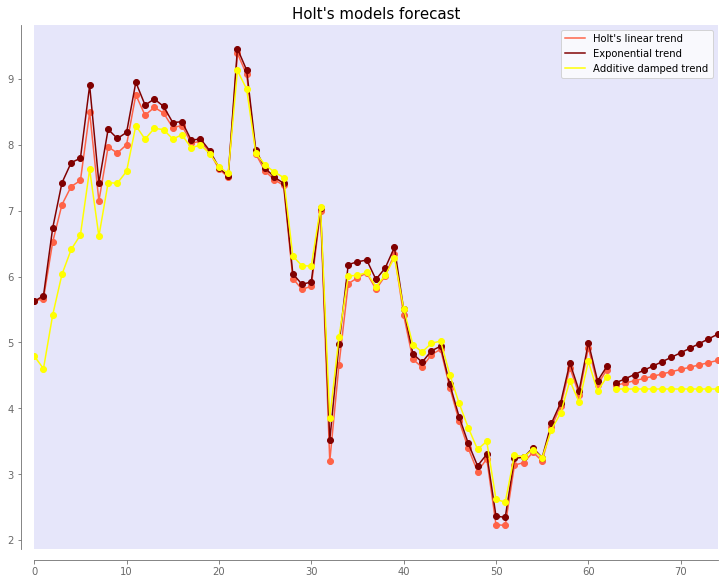

In [13]:
holt_linear = Holt(log_diff_china_confirmed_df).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
forecast_holt_linear = holt_linear.forecast(12).rename("Holt's linear trend")

holt_exponential = Holt(log_diff_china_confirmed_df, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
forecast_holt_exponential = holt_exponential.forecast(12).rename("Exponential trend")

holt_additive = Holt(log_diff_china_confirmed_df, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
forecast_holt_additive = holt_additive.forecast(12).rename("Additive damped trend")

fig = plt.figure(figsize= [10,8],constrained_layout=True)
Holt_plot = fig.gca()
Holt_plot.set_facecolor('lavender')
Holt_plot.set_title("Holt's models forecast", fontsize = 15)
Holt_plot.grid(color='ghostwhite', linestyle='--', linewidth=1)
Holt_plot.spines['bottom'].set_position(('axes', -0.02))
Holt_plot.spines['left'].set_position(('axes', -0.02))
Holt_plot.spines['top'].set_color('none')
Holt_plot.spines['right'].set_color('none')
Holt_plot.tick_params(axis='x', colors='dimgray')
Holt_plot.tick_params(axis='y', colors='dimgray')
Holt_plot.xaxis.set_tick_params(color = 'dimgray', labelsize=10, rotation = 30)
Holt_plot.yaxis.set_tick_params(color = 'dimgray', labelsize=10)


forecast_holt_linear.plot(marker='o', color='tomato', legend=True)
holt_linear.fittedvalues.plot(marker='o',  color='tomato')

forecast_holt_exponential.plot(marker='o', color='maroon', legend=True)
holt_exponential.fittedvalues.plot(marker='o',  color='maroon')

forecast_holt_additive.plot(marker='o', color='yellow', legend=True)
holt_additive .fittedvalues.plot(marker='o',  color='yellow')

plt.show()

In [14]:
forecast_holt_linear_real = []
for forecast in forecast_holt_linear:
    real_forecast = exp(forecast)
    forecast_holt_linear_real.append(real_forecast)
    
    
forecast_holt_exponential_real = []
for forecast in forecast_holt_exponential:
    real_forecast = exp(forecast)
    forecast_holt_exponential_real.append(real_forecast)


forecast_holt_additive_real = []
for forecast in forecast_holt_additive:
    real_forecast = exp(forecast)
    forecast_holt_additive_real.append(real_forecast)
    
      

real_forecasts_China_Holt = {"Holt's linear trend": forecast_holt_linear_real, 'Exponential trend': forecast_holt_exponential_real, 'Additive damped trend': forecast_holt_additive_real}

index_Holt = []
for i in range(1,13):
    index_Holt.append('Forecast ' + str(i))
    

real_forecasts_China_Holt = pd.DataFrame(real_forecasts_China_Holt)
real_forecasts_China_Holt.index = index_Holt
print(real_forecasts_China_Holt)

             Holt's linear trend  Exponential trend  Additive damped trend
Forecast 1             77.499084          80.426521              73.280051
Forecast 2             80.198134          85.604804              73.280051
Forecast 3             82.991185          91.197388              73.280051
Forecast 4             85.881508          97.242820              73.280051
Forecast 5             88.872492         103.783696              73.280051
Forecast 6             91.967643         110.867131              73.280051
Forecast 7             95.170589         118.545284              73.280051
Forecast 8             98.485083         126.875964              73.280051
Forecast 9            101.915010         135.923301              73.280051
Forecast 10           105.464391         145.758510              73.280051
Forecast 11           109.137386         156.460757              73.280051
Forecast 12           112.938300         168.118138              73.280051
